In [1]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.preprocessing import StandardScaler
from torchtext import data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from collections import Counter

In [92]:

# this needs to be cleaned up and data can be grouped in a more efficient way 

path= '/Users/tancredicp/Desktop/sailing_app/data/MLRestricted'
all_files = glob.glob(path + "/*.csv")


Data = []
for filename in all_files:
    
    roll_param = '5s'
    offset =  1
    
    
    #read file 
    dfSpecific = pd.read_csv(filename, index_col=None, header=0)
    dfSpecific.fillna(0, inplace= True)
    dfSpecific['time'] = pd.to_datetime(dfSpecific['time']).dt.tz_localize(None)
    
    
    #differentiating nominal values 
    
    #calculate acceleration
    dv = dfSpecific['sog'].diff() / dfSpecific['time'].diff().dt.total_seconds()
    
    #calculate dtheta/dt
    #formule required to deal with the fact data comes in form of -1 to 1
    dtheta = dfSpecific['cog'].diff().abs()  
    dtheta = [2-i if i > 1 else  i for i in dtheta]
    dtheta = dtheta / dfSpecific['time'].diff().dt.total_seconds()
    
    

    
    #adding rolling windows 
    
    dfFeatures = dfSpecific[['sog', 'time']]
    

    # acceleration
    dfFeatures['a'] = dv
    #dfFeatures[['sogDelta']].rolling(roll_param1, center = True).mean()
    dfFeatures['aR'] =  dfFeatures.set_index('time', drop=True)[['a']].rolling(roll_param).mean()
    dfFeatures['aR'].fillna(dfFeatures['a'], inplace=True)

    #
    dfFeatures['dtheta'] = dtheta
    dfFeatures['dthetaR'] = dfFeatures.set_index('time', drop=True)[['dtheta']].rolling(roll_param).mean()
    dfFeatures['dthetaR'].fillna(dfFeatures['dtheta'], inplace=True)
    
    dfFeatures.drop(columns = 'time', inplace = True)
    
    
    #standardizing 
    
#     scaler = StandardScaler()
#     arrayFeaturesScaled = scaler.fit_transform(dfFeatures)
    
    
    
    dfFeatures =  dfFeatures #pd.DataFrame(arrayFeaturesScaled, columns=dfFeatures.columns)
    
    
    #drop first value since there will be nans for delta fields
    dfFeatures = dfFeatures[1:]
    
    #tags
    
    dfTag = dfSpecific[['tag']][1:]
    dfTag.fillna(0, inplace= True)
    
    TAGS = data.Field(unk_token = None)
    TAGS.build_vocab(['A','B','D','G','S','T'])
    dfTag['tag'] = np.array(TAGS.numericalize((np.array(dfTag['tag']))))[0]
    
    dfFeatures['tag'] =  dfTag['tag']
    
    
    Data.append(dfFeatures)

In [93]:
MasterFrame = pd.concat(Data)

In [94]:
MasterFrame.describe()

,sog,a,aR,dtheta,dthetaR,tag
count,39017.000000,39017.000000,39017.000000,39017.000000,39017.000000,39017.000000
mean,9.378433,0.007212,0.007212,0.018968,0.018968,4.791373
std,3.025025,0.583446,0.583446,0.025342,0.025342,0.821833
min,0.330000,-5.410000,-5.410000,0.000000,0.000000,1.000000
25%,7.450000,-0.270000,-0.270000,0.005556,0.005556,5.000000
50%,8.680000,0.000000,0.000000,0.011111,0.011111,5.000000
75%,11.230000,0.280000,0.280000,0.022222,0.022222,5.000000
max,19.810000,3.510000,3.510000,0.527778,0.527778,6.000000


In [95]:
MasterFrame['dtheta'][100:110]

101    0.005556
102    0.005556
103    0.022222
104    0.011111
105    0.000000
106    0.005556
107    0.005556
108    0.000000
109    0.022222
110    0.005556
Name: dtheta, dtype: float64

In [96]:
MasterFrame.isna().sum()

sog        0
a          0
aR         0
dtheta     0
dthetaR    0
tag        0
dtype: int64

In [97]:
X = MasterFrame[['sog', 'a', 'aR', 'dtheta', 'dthetaR']]
y = MasterFrame[['tag']]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 3, test_size = 0.5, shuffle = False)

In [100]:
RFC = RandomForestClassifier(n_estimators= 100)
RFC.fit(X_train,y_train)
RFC.score(X_train, y_train), RFC.score(X_test, y_test)

(0.9754972319048596, 0.852580860115844)

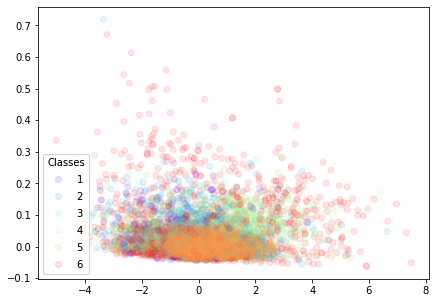

In [101]:
fig, ax = plt.subplots(figsize = (7,5))


c = MasterFrame['tag']
pca = PCA()
array = pca.fit_transform(X)
scatter = ax.scatter(array[:,1], array[:,2], c=c, cmap = 'rainbow', alpha = 0.1, label = c)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [60]:
MasterFrame

,sog,sogDelta,sogDeltaRoll,cogDelta,cogDeltaRoll,tag
1,-1.292945,-0.028928,-0.028928,-0.414145,-0.414145,5
2,-1.803548,-0.871056,-0.871056,0.505397,0.505397,5
3,-1.675897,0.181604,0.181604,-0.414145,-0.414145,5
4,-1.037644,1.023732,1.023732,1.424939,1.424939,5
5,-0.399392,1.023732,1.023732,0.505397,0.505397,5
...,...,...,...,...,...,...
43,0.463515,-0.528591,-0.528591,-0.420988,-0.420988,5
44,0.290598,-0.399866,-0.399866,-0.420988,-0.420988,5
45,0.405876,0.243754,0.243754,-0.279150,-0.279150,5
46,0.002402,-0.914763,-0.914763,-0.137312,-0.137312,5
